# Wikipedia mapping

In [1]:
#Load modules
from bs4 import BeautifulSoup
from itertools import compress
import requests
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#Special line for Jupyter Notebook. Does not appear in the source code.
%matplotlib inline

## Crawler functions

In [2]:
#Get links from article
def get_internal_links(article):
    """
    Takes the name of a wikipedia article as input and returns all internal
    link the article refers to.
    --------------
    Input:  - article : String
             e.g. 'Python_(programming_language)'
    
    Output: - links   : List of Strings
             e.g. ['Guido_van_Rossum', 'Interpreted_language', 'XML', ...]
    """
    links = [] #Initialize an empty list of links
    url = 'https://en.wikipedia.org/wiki/' + article
    #Build the BeautifulSoup item
    soup = BeautifulSoup(requests.get(url).content, 'lxml')
    #Iterate over all links within the content of the wikipedia article
    for a in soup.find('div', {'id': 'mw-content-text'}).findAll('a'):
        href = a.get('href')
        if href is None: #Some links have an empty href, skip them
            continue
        elif href[:6] == '/wiki/': #This is an internal link to an article
            #Links with ':' are special links such as Files or BookSources
            #Disambiguation links also cause problems
            if not (':' in href in href or href[6:] in links or '(disambiguation)' in href):
                if not 'List_of_' in href: #Comment out to keep Lists of () articles
                    links.append(href[6:]) #Only append the name of the article
    return links




#Crawl list of links
def crawl(article, 
          searchFirst='breadth', 
          maxItems=1000, 
          maxBreadth=0, 
          maxDepth=0,
          silent=False):
    """
    Takes the name of a wikipedia article 'article' as starting point 
    and crawls through all internal links until a total of 'maxItems' are
    reached. It thens returns a dictionary containing all the items scraped and
    their internal links.
    --------------
    Input:  - article     : String
             e.g. 'Python_(programming_language)'
            - searchFirst : String
             either 'breadth' or 'depth'
            - maxItems    : Int
             e.g. 1000
            - maxBreadth  : Int
             e.g. 10, if 0 then it will use maximum breadth
            - maxDepth    : Int
             e.g. 5, if 0 then it will use maximum depth
            - silent      : Boolean
             will print the options used at the beginning if silent=False
    Output: - results  : Dictionary
             e.g. {'startingArticle': [link1, link2, link3, ...],
                   'link1'          : [link132, link133, link51, ...],
                   ...}
    """    
    print(article)
    #Define initial variables
    itemCount = 0 #Initialize the item counter
    links = get_internal_links(article)
    if maxBreadth > 0:
        links = links[:maxBreadth]
    network = {article:links} #Initialize the output dictionary
    depth = {article: 1} #Initialize the depth dictionary, for maxDepth control
    scraped = [] #List of fully scraped articles (all internal links have been scraped according to maxBreadth/Depth)
    depth_scraped = [] #Similar list as above for depth-search only
    depthSearch = (searchFirst=='depth') #Set the boolean to handle depth-first search
    skip = False #Boolean used for depth-search only

    #Handle wrong inputs for searchFirst
    #TODO: Handle all wrong inputs?
    if searchFirst!='breadth' and searchFirst!='depth':
        print("Unexpected input for searchFirst, please chose one of 'breadth/depth'")
        raise
    if silent==False:
        #Print starting output
        print('Running Wikipedia crawler with the following options: ')
        print('{}-first search,'.format(searchFirst))
        print('maxItems  : {},'.format(maxItems))
        print('maxBreadth: {},'.format(maxBreadth))
        print('maxDepth  : {}\n\n'.format(maxDepth))
        
    #Repeat this step until we reach the maxItems threshold
    while itemCount <= maxItems:
        #Iterate over the keys who aren't fully scraped according to maxBreadth/Depth (nodes)
        if depthSearch:
            keys = [k for k in network.keys() if k not in depth_scraped]
            if len(keys)==0: #Max depth reached
                keys = [k for k in network.keys() if k not in scraped]
        else:
            keys = [k for k in network.keys() if k not in scraped]
        #We have scraped everything allowed by maxBreadth/Depth
        if len(keys)==0:
            return network
        #Iterate over nodes that haven't been scraped
        for k in keys:
            if maxDepth == 0 or maxDepth > depth[k]:
                print('key :', k) #Temp debug line
                #Iterate over the values (edges / relationships / internal links)
                for v in get_internal_links(k):
                    print(k, '-', 'Item', itemCount, ':', v) #Temp debug line
                    if v not in network.keys(): #Add them to the keys if not present
                        links = get_internal_links(v) #Get the internal links
                        if maxBreadth == 0: #Set the max breadth as large as possible
                            maxBreadth = len(links)
                            mB = maxBreadth
                        #Special case for depth-first search
                        elif depthSearch:
                            mB = maxBreadth #Use np.isin() with numpy 1.13
                            while len(links[:mB]) - sum(np.in1d(links[:mB], list(network.keys()))) == 0:
                                mB += 1
                        else:
                            mB = maxBreadth
                        #Add the edge entry as a node 
                        network[v] = links[:mB] #Only assign links up to maxBreadth
                        depth[v] = depth[k] + 1 #Set the depth on the children-node
                        itemCount += 1
                        if silent==False and itemCount % 25 == 0:
                            print('{:6} items scraped. - last one: {}'.format(itemCount, v))
                        #Exit if we have reached the max item threshold
                        if itemCount >= maxItems:
                            return network
                        if depthSearch:
                            depth_scraped.append(k) #Append the father-node to the special list
                            skip = True
                            break #Only add the first edge as a node
            if skip==True:
                skip = False
                break
            else:
                scraped.append(k) #The node doesn't have to be scraped again
                depth_scraped.append(k)
            if itemCount >= maxItems:
                return network
    return network

## Network Plotting Help Functions

In [3]:
#Clean data by dropping endnodes
def drop_endnodes(data):
    """
    Takes the 'data' dictionary used to build a networkx.Graph object.
    Cleans the network by dropping the endnodes that add nothing to the graph.
    Returns a modified dictionary 'data' without endnodes.
    --------------
    Input:  - data    : Dictionary
             e.g. {'article1': ['article2', 'article3', ...],
                   'article2': ['article13', 'article7', ...],
                   ...}
    Output: - newData : Dictionary
             e.g. {'article1': ['article2', 'article3', ...],
                   'article2': ['article13', 'article7', ...],
    """
    newData = data
    for k1, v1 in data.items():
        msk = np.in1d(list(v1), list(data.keys())) #Keep values that are also nodes (keys)
        for k2, v2 in data.items():
            if k1 != k2:
                msk2 = np.in1d(list(v1), list(v2)) #Keep values, that have multiple nodes connections
                #OR-filter on msk, True if at least 1 is True, else False
                msk = [max(msk[i], msk2[i]) for i in range(len(v1))]
        newData[k1] = list(compress(v1, msk)) #Filter out items that don't belong to msk


        
        
#Build networkx.Graph object and draw chart
def summarize_crawl(data, plotTitle='', with_labels=False, 
                    cmap='Wistia', keep_end_nodes=False):
    """
    Takes a 'data' dictionary and some formatting options.
    Creates a networkx.Graph object and plot it, print the run-time and return nothing.
    --------------
    Input:  - data              : Dictionary
             e.g. {'article1': ['article2', 'article3', ...],
                   'article2': ['article13', 'article7', ...],
                   ...}
            - plotTitle         : String (default='')
             e.g. 'Generic Plot Title'
            - with_labels       : Boolean (default=False)
             prints the labels on the nodes when plotting
            - cmap              : String (default='Wistia')
             e.g. 'viridis', 'Wistia, 'YlGnBu'
             see: https://matplotlib.org/examples/color/colormaps_reference.html
            - keep_end_nodes    : Boolean (default=False)
             keep end-nodes, i.e. nodes that have only 1 edge (single values in the 'data' dictionary)
                 WARNING: setting this option to True with large 'data' dictionary 
                          can tremendously slow down the plotting process
    Output: - None
    """
    #Clean crawl data (we remove 'end-nodes', i.e. values that are not present in the keys or other values)
    if not keep_end_nodes:
        drop_endnodes(network)
    
    #Transform the data to a networkx Graph object
    G = nx.Graph(network)
    #Print the size of the network
    print('The network has {} nodes and {} edges'.format(len(G.nodes()), len(G.edges())))

    mapping = [] #Initialize output
    for node in G.nodes():
        if node in network.keys():
            mapping.append(len(network[node])) #Append the count of values if the node is a key
        else:
            mapping.append(0) #0 if the node is not a key

    plt.figure(figsize=(30,15)) #Set plot size
    plt.title(plotTitle) #Set plot title
    #Draw the graph (careful, can be very long)
    nx.draw(G,
            node_color=mapping,
            with_labels=with_labels,
            cmap=cmap)

## Main Program

### Constants

In [6]:
#Define constants
article = 'Rayman' #Starting article
sF = 'depth'    #Search-First: 'breadth' or 'depth'
mB = 0          #Max breadth
mD = 0          #Max depth
mI = 10         #Max items

### Call main functions

In [7]:
#Crawl
network = crawl(article=article, searchFirst=sF, maxBreadth=mB,
                maxDepth=mD,maxItems=mI)

Rayman
Running Wikipedia crawler with the following options: 
depth-first search,
maxItems  : 10,
maxBreadth: 0,
maxDepth  : 0


key : Rayman
Rayman - Item 0 : Rayman_(character)
key : Rayman_(character)
Rayman_(character) - Item 1 : Rayman
Rayman_(character) - Item 1 : Rayman_(video_game)
key : Rayman_(video_game)
Rayman_(video_game) - Item 2 : Video_game_developer
key : Video_game_developer
Video_game_developer - Item 3 : Video_game_industry
key : Video_game_industry
Video_game_industry - Item 4 : Video_game_design
key : Video_game_design
Video_game_design - Item 5 : Video_game_industry
Video_game_design - Item 5 : Game_design
key : Game_design
Game_design - Item 6 : Video_game_design
Game_design - Item 6 : Design
key : Design
Design - Item 7 : Plan_(drawing)
key : Plan_(drawing)
Plan_(drawing) - Item 8 : Drawing
key : Drawing
Drawing - Item 9 : Rembrandt


The network has 73 nodes and 174 edges


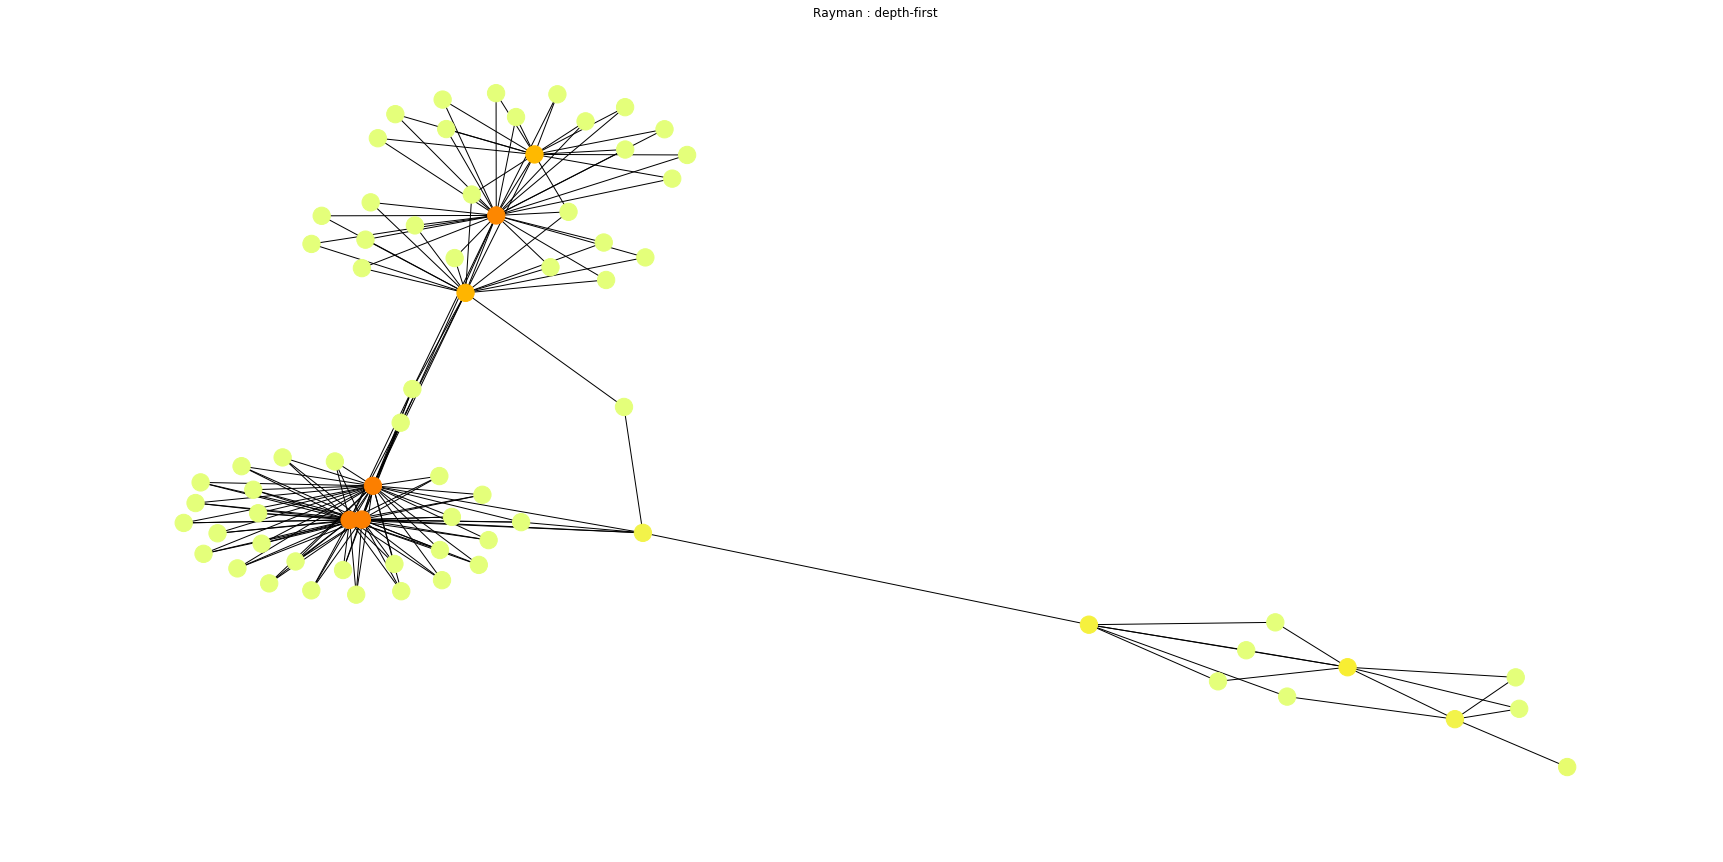

In [8]:
#Draw graph
summarize_crawl(data=network, plotTitle='{} : {}-first'.format(article, sF),
                keep_end_nodes=False)